APARTADO 2: INTEGRACIÓN Y SELECCIÓN DE DATOS DE PELÍCULAS (1980-1989)
Mounted at /content/drive

CARGA DEL DATASET BASE
--------------------------------------------------
Dataset base cargado: 300 películas × 16 variables
Período: 1980 - 1989
Películas con URL de IMDb disponible: 300/300 (100.0%)

ESTRUCTURA DEL DATASET BASE:
Variables FilmAffinity: 9
Variables IMDb básicas: 3
Total variables actuales: 16

PROCESO DE INTEGRACIÓN
--------------------------------------------------
Variables financieras a integrar: 4
Iniciando extracción de datos financieros...

[  1/300] The Shining (1980)
Datos financieros integrados
      Presupuesto Millones: $19.0M
      Recaudacion Domestica Millones: $45.63M
      Recaudacion Mundial Millones: $47.96M
      Estreno Millones: $0.62M

[  2/300] Star Wars. Episode V: The Empire Strikes Back (1980)
Datos financieros integrados
      Presupuesto Millones: $18.0M
      Recaudacion Domestica Millones: $292.75M
      Recaudacion Mundial Millones: $550.02M


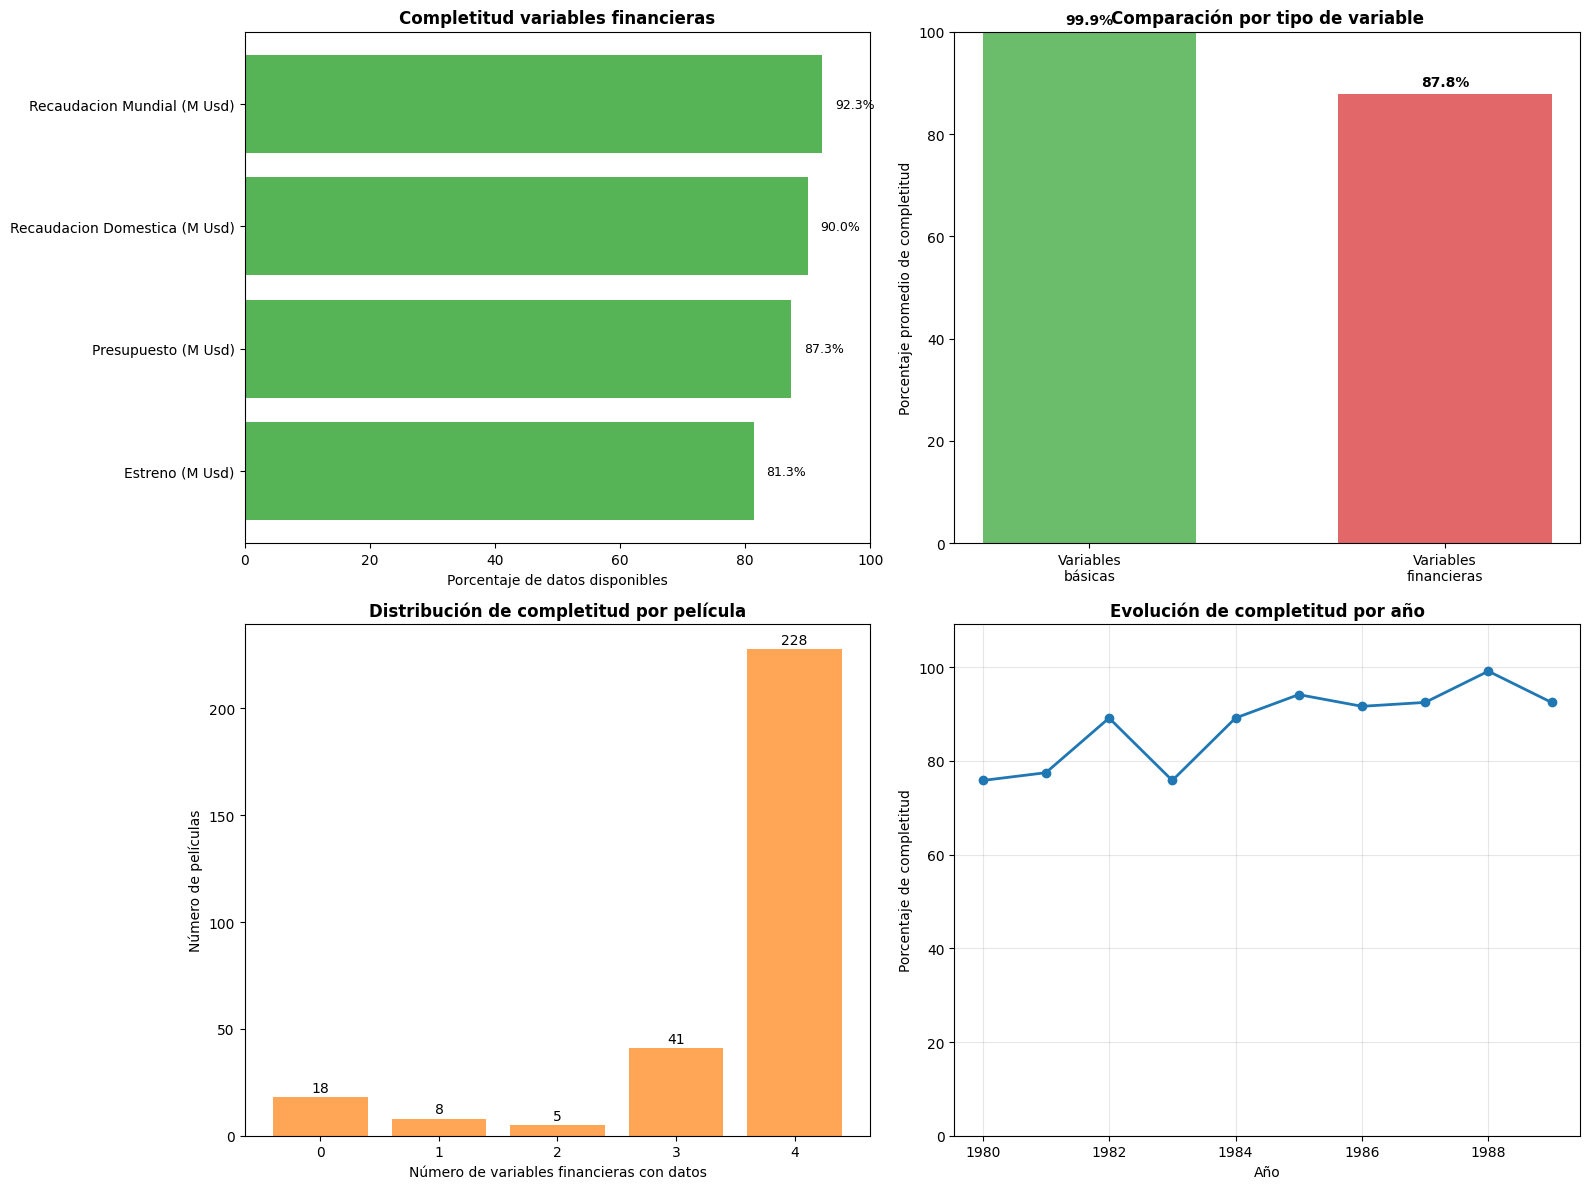

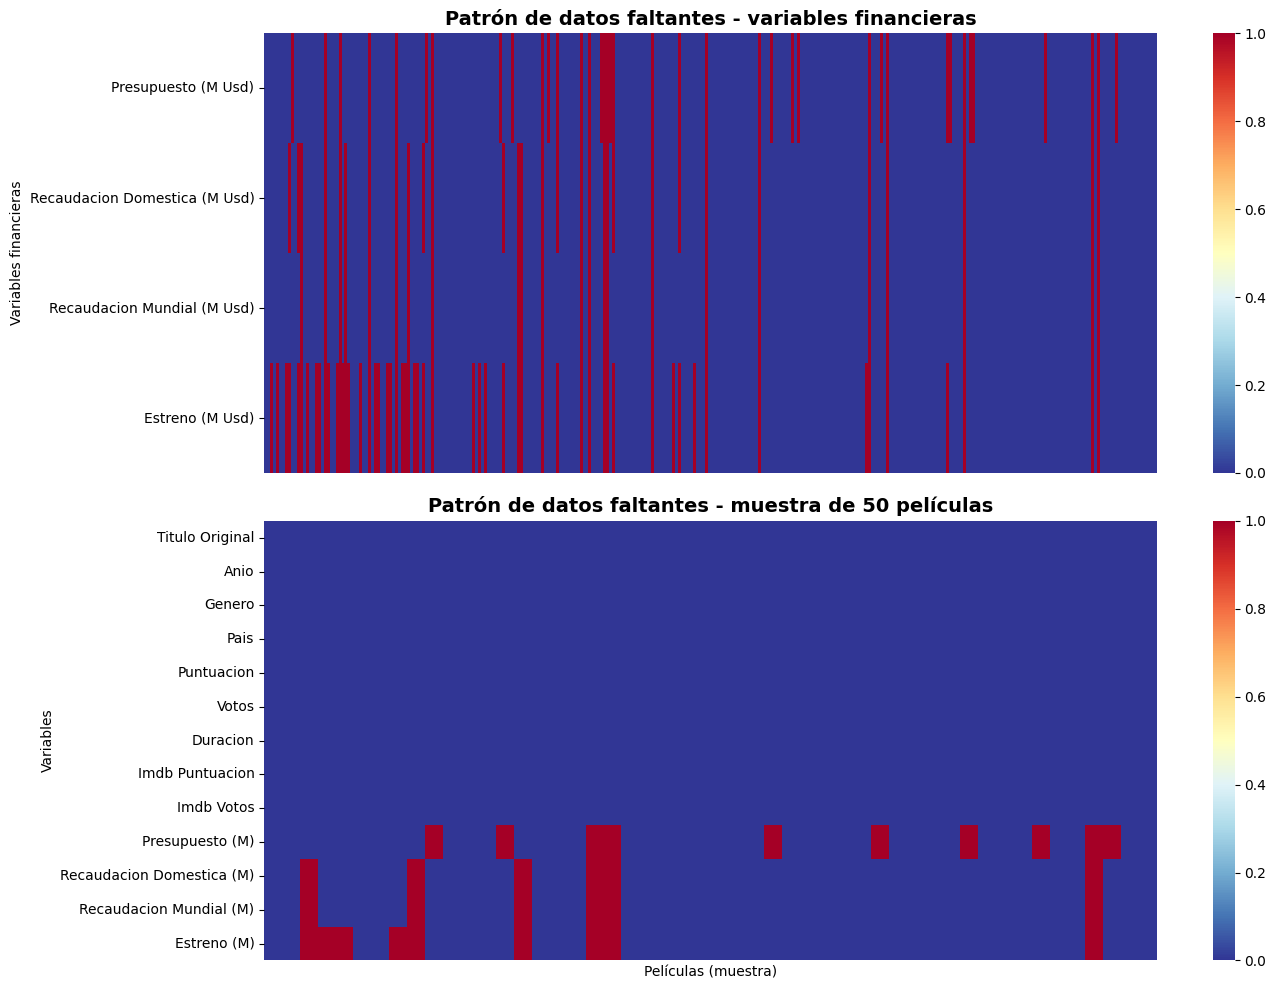


GUARDADO DEL DATASET INTEGRADO
--------------------------------------------------
Dataset integrado guardado: /content/drive/MyDrive/Tipología/PR2/datasets/paso02a-peliculas_filmaffinity_1980-1989_imdb_integracion.csv
Fecha y hora: 2025-05-27 01:05:14

MUESTRA DEL DATASET INTEGRADO:
--------------------------------------------------
                                 titulo_original  anio  puntuacion  imdb_puntuacion presupuesto_millones recaudacion_domestica_millones recaudacion_mundial_millones estreno_millones
0                                    The Shining  1980         8.2              8.4                 19.0                          45.63                        47.96             0.62
1  Star Wars. Episode V: The Empire Strikes Back  1980         8.1              8.7                 18.0                         292.75                       550.02             4.91
2                                      Airplane!  1980         6.4              7.7                  3.5              

In [1]:
# ============================================================================
# APARTADO 2A: INTEGRACIÓN Y SELECCIÓN DE DATOS
# Integración de datos financieros de IMDb al dataset
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import random
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("="*70)
print("APARTADO 2: INTEGRACIÓN Y SELECCIÓN DE DATOS DE PELÍCULAS (1980-1989)")
print("="*70)

# ============================================================================
# CARGA DEL DATASET BASE
# ============================================================================

# Montar Google Drive
from google.colab import drive
drive.mount("/content/drive")

print("\nCARGA DEL DATASET BASE")
print("-" * 50)

# Cargar dataset con datos básicos de IMDb
df_base = pd.read_csv("/content/drive/MyDrive/Tipología/PR2/datasets/peliculas_filmaffinity_1980-1989_imdb.csv",
                     sep=';', encoding='utf-8')

print(f"Dataset base cargado: {df_base.shape[0]} películas × {df_base.shape[1]} variables")
print(f"Período: {df_base['anio'].min()} - {df_base['anio'].max()}")

# Verificar datos necesarios para integración
peliculas_con_imdb = df_base['imdb_url'].notna().sum()
print(f"Películas con URL de IMDb disponible: {peliculas_con_imdb}/{len(df_base)} ({peliculas_con_imdb/len(df_base)*100:.1f}%)")

print("\nESTRUCTURA DEL DATASET BASE:")
variables_filmaffinity = ['titulo_original', 'anio', 'genero', 'pais', 'direccion',
                         'puntuacion', 'votos', 'duracion', 'sinopsis']
variables_imdb_basicas = ['imdb_url', 'imdb_puntuacion', 'imdb_votos']

print("Variables FilmAffinity:", len([col for col in variables_filmaffinity if col in df_base.columns]))
print("Variables IMDb básicas:", len([col for col in variables_imdb_basicas if col in df_base.columns]))
print("Total variables actuales:", len(df_base.columns))

# ============================================================================
# FUNCIONES DE EXTRACCIÓN DE DATOS FINANCIEROS
# ============================================================================

def extraer_datos_financieros_imdb(url_imdb, titulo_pelicula):
    """
    Extrae datos financieros específicos de IMDb

    Args:
        url_imdb (str): URL de la película en IMDb
        titulo_pelicula (str): Título para logging

    Returns:
        dict: Diccionario con datos financieros en millones USD
    """
    cabeceras = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        respuesta = requests.get(url_imdb, headers=cabeceras)

        if respuesta.status_code != 200:
            return {}

        sopa = BeautifulSoup(respuesta.text, 'html.parser')
        datos = {}

        def convertir_a_millones(texto_monetario):
            """Convierte texto monetario a millones de dólares"""
            if not texto_monetario:
                return None

            # Limpiar texto: remover USD, espacios, comas, paréntesis
            texto_limpio = texto_monetario.replace('USD', '').replace('\xa0', ' ').replace(',', '')
            texto_limpio = re.sub(r'\(.*?\)', '', texto_limpio).strip()

            # Extraer números
            match = re.search(r'(\d+(?:\.\d+)?)', texto_limpio)

            if match:
                valor = float(match.group(1))
                return round(valor / 1_000_000, 2)
            return None

        # Extraer datos usando selectores CSS específicos
        elementos = {
            'presupuesto_millones': 'li[data-testid="title-boxoffice-budget"] .ipc-metadata-list-item__list-content-item',
            'recaudacion_domestica_millones': 'li[data-testid="title-boxoffice-grossdomestic"] .ipc-metadata-list-item__list-content-item',
            'recaudacion_mundial_millones': 'li[data-testid="title-boxoffice-cumulativeworldwidegross"] .ipc-metadata-list-item__list-content-item'
        }

        for variable, selector in elementos.items():
            try:
                elemento = sopa.select_one(selector)
                if elemento:
                    texto = elemento.text.strip()
                    datos[variable] = convertir_a_millones(texto)
                else:
                    datos[variable] = None
            except:
                datos[variable] = None

        # Fin de semana de estreno (tomar solo el primer elemento - monto)
        try:
            estreno_elems = sopa.select('li[data-testid="title-boxoffice-openingweekenddomestic"] .ipc-metadata-list-item__list-content-item')
            if estreno_elems and len(estreno_elems) > 0:
                estreno_texto = estreno_elems[0].text.strip()
                datos['estreno_millones'] = convertir_a_millones(estreno_texto)
            else:
                datos['estreno_millones'] = None
        except:
            datos['estreno_millones'] = None

        return datos

    except Exception as e:
        return {}

# ============================================================================
# PROCESO DE INTEGRACIÓN DE DATOS
# ============================================================================

print("\nPROCESO DE INTEGRACIÓN")
print("-" * 50)

# Preparar nuevas columnas
nuevas_variables_financieras = [
    'presupuesto_millones',
    'recaudacion_domestica_millones',
    'recaudacion_mundial_millones',
    'estreno_millones'
]

# Crear copia del dataset para integración
df_integrado = df_base.copy()

# Inicializar nuevas columnas
for columna in nuevas_variables_financieras:
    df_integrado[columna] = None

print(f"Variables financieras a integrar: {len(nuevas_variables_financieras)}")
print("Iniciando extracción de datos financieros...")

# Contadores para estadísticas
peliculas_procesadas = 0
peliculas_con_datos = 0
peliculas_sin_url = 0

# Procesar cada película
for indice, fila in df_integrado.iterrows():
    titulo = fila['titulo_original']
    año = fila['anio']
    url_imdb = fila.get('imdb_url')

    print(f"\n[{indice+1:3d}/{len(df_integrado)}] {titulo} ({año})")

    # Verificar URL de IMDb
    if pd.isna(url_imdb) or not url_imdb:
        print("Sin URL de IMDb - saltando")
        peliculas_sin_url += 1
        continue

    # Extraer datos financieros
    datos_financieros = extraer_datos_financieros_imdb(url_imdb, titulo)

    if datos_financieros:
        # Actualizar dataset
        for variable, valor in datos_financieros.items():
            df_integrado.at[indice, variable] = valor

        peliculas_procesadas += 1

        # Verificar si obtuvo datos
        datos_disponibles = [datos_financieros.get(var) for var in nuevas_variables_financieras]
        if any(dato is not None for dato in datos_disponibles):
            peliculas_con_datos += 1
            print("Datos financieros integrados")

            # Mostrar datos extraídos
            for var in nuevas_variables_financieras:
                valor = datos_financieros.get(var)
                if valor is not None:
                    print(f"      {var.replace('_', ' ').title()}: ${valor}M")
        else:
            print("Sin datos financieros disponibles")
    else:
        print("Error en extracción")

    # Pausa para no sobrecargar servidor
    time.sleep(random.uniform(2, 4))

# ============================================================================
# RESUMEN DE INTEGRACIÓN
# ============================================================================

print("\n" + "="*70)
print("RESUMEN DE INTEGRACIÓN COMPLETADA")
print("="*70)

print(f"\nESTADÍSTICAS DE PROCESAMIENTO:")
print(f"Total películas en dataset: {len(df_integrado)}")
print(f"Películas con URL IMDb: {len(df_integrado) - peliculas_sin_url}")
print(f"Películas procesadas: {peliculas_procesadas}")
print(f"Películas con datos financieros: {peliculas_con_datos}")
print(f"Tasa de éxito: {peliculas_con_datos/peliculas_procesadas*100:.2f}%")

print(f"\nDISPONIBILIDAD POR VARIABLE FINANCIERA:")
for variable in nuevas_variables_financieras:
    cantidad = df_integrado[variable].count()
    porcentaje = (cantidad / len(df_integrado)) * 100
    print(f"{variable.replace('_', ' ').title()}: {cantidad}/{len(df_integrado)} ({porcentaje:.1f}%)")

# ============================================================================
# ANÁLISIS DEL DATASET INTEGRADO
# ============================================================================

print("\nANÁLISIS DEL DATASET INTEGRADO")
print("-" * 50)

# Dimensiones finales
print(f"Dimensiones finales: {df_integrado.shape[0]} filas × {df_integrado.shape[1]} columnas")

# Clasificación de variables por fuente
variables_filmaffinity = len([col for col in df_integrado.columns
                             if not col.startswith('imdb_') and col not in nuevas_variables_financieras])
variables_imdb_basicas = len([col for col in df_integrado.columns
                             if col.startswith('imdb_') and col not in nuevas_variables_financieras])
variables_financieras = len(nuevas_variables_financieras)

print(f"\nCLASIFICACIÓN POR FUENTE:")
print(f"Variables FilmAffinity: {variables_filmaffinity}")
print(f"Variables IMDb básicas: {variables_imdb_basicas}")
print(f"Variables financieras: {variables_financieras}")
print(f"Total variables: {df_integrado.shape[1]}")

# Estadísticas descriptivas de variables financieras
datos_financieros_disponibles = df_integrado[nuevas_variables_financieras].dropna(how='all')

if len(datos_financieros_disponibles) > 0:
    print(f"\nESTADÍSTICAS FINANCIERAS ({len(datos_financieros_disponibles)} películas con datos):")
    estadisticas_financieras = df_integrado[nuevas_variables_financieras].describe()
    print(estadisticas_financieras.round(2))

# ============================================================================
# VALIDACIÓN DE LA INTEGRACIÓN
# ============================================================================

print("\nVALIDACIÓN DE LA INTEGRACIÓN")
print("-" * 50)

# Verificar consistencia de datos
print("VERIFICACIONES DE CONSISTENCIA:")

# 1. Recaudación mundial >= Recaudación doméstica
recaudacion_consistente = df_integrado[
    (df_integrado['recaudacion_mundial_millones'].notna()) &
    (df_integrado['recaudacion_domestica_millones'].notna())
]

if len(recaudacion_consistente) > 0:
    inconsistencias = recaudacion_consistente[
        recaudacion_consistente['recaudacion_mundial_millones'] <
        recaudacion_consistente['recaudacion_domestica_millones']
    ]
    print(f"Recaudación mundial >= doméstica: {len(recaudacion_consistente) - len(inconsistencias)}/{len(recaudacion_consistente)} ✓")

# 2. Datos financieros positivos
datos_negativos = df_integrado[nuevas_variables_financieras].lt(0).sum().sum()
print(f"Todos los valores financieros >= 0: {datos_negativos == 0} ✓")

# 3. Completitud por década/año
print(f"\nCOMPLETITUD POR AÑO:")
for año in sorted(df_integrado['anio'].unique()):
    peliculas_año = df_integrado[df_integrado['anio'] == año]
    con_datos_financieros = peliculas_año[nuevas_variables_financieras].dropna(how='all').shape[0]
    print(f"{año}: {con_datos_financieros}/{len(peliculas_año)} películas ({con_datos_financieros/len(peliculas_año)*100:.2f}%)")

# ============================================================================
# ANÁLISIS EXPLORATORIO DE DATOS FINANCIEROS INTEGRADOS
# ============================================================================

print("\n" + "="*70)
print("ANÁLISIS EXPLORATORIO DE DATOS FINANCIEROS INTEGRADOS")
print("="*70)

# Variables para el análisis
variables_principales = ['titulo_original', 'anio', 'genero', 'pais', 'puntuacion',
                        'votos', 'duracion', 'imdb_puntuacion', 'imdb_votos']

# ============================================================================
# 1. ANÁLISIS DE COMPLETITUD
# ============================================================================

print("\n1. ANÁLISIS DE COMPLETITUD")
print("-" * 50)

# Calcular completitud por variable
completitud = pd.DataFrame({
    'Variable': df_integrado.columns,
    'Valores_Disponibles': df_integrado.count(),
    'Valores_Faltantes': df_integrado.isnull().sum(),
    'Porcentaje_Disponible': (df_integrado.count() / len(df_integrado)) * 100,
    'Porcentaje_Faltante': (df_integrado.isnull().sum() / len(df_integrado)) * 100
})

# Resumen de variables financieras
print("VARIABLES FINANCIERAS INTEGRADAS:")
for var in nuevas_variables_financieras:
    row = completitud[completitud['Variable'] == var].iloc[0]
    print(f"  {var.replace('_', ' ').title():30s}: {row['Valores_Disponibles']:3d}/{len(df_integrado)} ({row['Porcentaje_Disponible']:5.2f}%)")

# Comparación con variables básicas
completitud_basicas = df_integrado[variables_principales].count().mean() / len(df_integrado) * 100
completitud_financieras = df_integrado[nuevas_variables_financieras].count().mean() / len(df_integrado) * 100
print(f"\nCOMPARACIÓN:")
print(f"Variables básicas (promedio):     {completitud_basicas:5.1f}%")
print(f"Variables financieras (promedio): {completitud_financieras:5.1f}%")

# Análisis de patrones de datos faltantes
print(f"\nPATRONES DE COMPLETITUD:")
sin_datos_financieros = df_integrado[df_integrado[nuevas_variables_financieras].isnull().all(axis=1)]
con_todos_datos = df_integrado[df_integrado[nuevas_variables_financieras].notnull().all(axis=1)]
con_datos_parciales = df_integrado[~df_integrado[nuevas_variables_financieras].isnull().all(axis=1) &
                                  ~df_integrado[nuevas_variables_financieras].notnull().all(axis=1)]

print(f"Sin datos financieros: {len(sin_datos_financieros)}/{len(df_integrado)} ({len(sin_datos_financieros)/len(df_integrado)*100:.1f}%)")
print(f"Con todos los datos: {len(con_todos_datos)}/{len(df_integrado)} ({len(con_todos_datos)/len(df_integrado)*100:.1f}%)")
print(f"Con datos parciales: {len(con_datos_parciales)}/{len(df_integrado)} ({len(con_datos_parciales)/len(df_integrado)*100:.1f}%)")

# ============================================================================
# 2. VISUALIZACIONES DE COMPLETITUD
# ============================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Completitud por variable financiera
completitud_fin = completitud[completitud['Variable'].isin(nuevas_variables_financieras)].copy()
completitud_fin = completitud_fin.sort_values('Porcentaje_Disponible')

colores = ['#d62728' if x < 30 else '#ff7f0e' if x < 60 else '#2ca02c'
           for x in completitud_fin['Porcentaje_Disponible']]

bars1 = ax1.barh(range(len(completitud_fin)), completitud_fin['Porcentaje_Disponible'],
                 color=colores, alpha=0.8)
ax1.set_yticks(range(len(completitud_fin)))
ax1.set_yticklabels([x.replace('_', ' ').replace('millones', '(M USD)').title()
                     for x in completitud_fin['Variable']])
ax1.set_xlabel('Porcentaje de datos disponibles')
ax1.set_title('Completitud variables financieras', fontweight='bold')
ax1.set_xlim(0, 100)

for i, v in enumerate(completitud_fin['Porcentaje_Disponible']):
    ax1.text(v + 2, i, f'{v:.1f}%', va='center', fontsize=9)

# Gráfico 2: Comparación por categorías
categorias = ['Variables\nbásicas', 'Variables\nfinancieras']
valores = [completitud_basicas, completitud_financieras]
colores_cat = ['#2ca02c', '#d62728']

bars2 = ax2.bar(categorias, valores, color=colores_cat, alpha=0.7, width=0.6)
ax2.set_ylabel('Porcentaje promedio de completitud')
ax2.set_title('Comparación por tipo de variable', fontweight='bold')
ax2.set_ylim(0, 100)

for bar, valor in zip(bars2, valores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Distribución de completitud por película
peliculas_con_datos_fin = df_integrado[nuevas_variables_financieras].count(axis=1)
distribucion = peliculas_con_datos_fin.value_counts().sort_index()

ax3.bar(distribucion.index, distribucion.values, color='#ff7f0e', alpha=0.7)
ax3.set_xlabel('Número de variables financieras con datos')
ax3.set_ylabel('Número de películas')
ax3.set_title('Distribución de completitud por película', fontweight='bold')
ax3.set_xticks(range(5))

for i, v in enumerate(distribucion.values):
    ax3.text(distribucion.index[i], v + 1, str(v), ha='center', va='bottom')

# Gráfico 4: Completitud por año
años = sorted(df_integrado['anio'].unique())
completitud_por_año = []

for año in años:
    df_año = df_integrado[df_integrado['anio'] == año]
    completitud_año = df_año[nuevas_variables_financieras].count().sum() / (len(df_año) * len(nuevas_variables_financieras)) * 100
    completitud_por_año.append(completitud_año)

ax4.plot(años, completitud_por_año, marker='o', linewidth=2, markersize=6, color='#1f77b4')
ax4.set_xlabel('Año')
ax4.set_ylabel('Porcentaje de completitud')
ax4.set_title('Evolución de completitud por año', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, max(completitud_por_año) + 10)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. HEATMAP DE DATOS FALTANTES
# ============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Heatmap 1: Solo variables financieras
matriz_faltantes_fin = df_integrado[nuevas_variables_financieras].isnull()
sns.heatmap(matriz_faltantes_fin.T,
            cbar=True,
            cmap='RdYlBu_r',
            ax=ax1,
            yticklabels=[x.replace('_', ' ').replace('millones', '(M USD)').title()
                        for x in nuevas_variables_financieras],
            xticklabels=False)
ax1.set_title('Patrón de datos faltantes - variables financieras', fontsize=14, fontweight='bold')
ax1.set_ylabel('Variables financieras')

# Heatmap 2: Comparación con variables principales
vars_para_comparacion = variables_principales + nuevas_variables_financieras
n_muestra = min(50, len(df_integrado))
indices_muestra = np.linspace(0, len(df_integrado)-1, n_muestra, dtype=int)
df_muestra = df_integrado.iloc[indices_muestra]

matriz_muestra = df_muestra[vars_para_comparacion].isnull()
sns.heatmap(matriz_muestra.T,
            cbar=True,
            cmap='RdYlBu_r',
            ax=ax2,
            yticklabels=[x.replace('_', ' ').replace('millones', '(M)').title()
                        for x in vars_para_comparacion],
            xticklabels=False)
ax2.set_title(f'Patrón de datos faltantes - muestra de {n_muestra} películas', fontsize=14, fontweight='bold')
ax2.set_ylabel('Variables')
ax2.set_xlabel('Películas (muestra)')

plt.tight_layout()
plt.show()

# ============================================================================
# GUARDADO DEL DATASET INTEGRADO
# ============================================================================

print("\nGUARDADO DEL DATASET INTEGRADO")
print("-" * 50)

# Guardar dataset integrado
archivo_salida = "/content/drive/MyDrive/Tipología/PR2/datasets/paso02a-peliculas_filmaffinity_1980-1989_imdb_integracion.csv"
df_integrado.to_csv(archivo_salida, sep=';', index=False, encoding='utf-8-sig')

print(f"Dataset integrado guardado: {archivo_salida}")
print(f"Fecha y hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Mostrar muestra del dataset integrado
print(f"\nMUESTRA DEL DATASET INTEGRADO:")
print("-" * 50)
muestra_columnas = ['titulo_original', 'anio', 'puntuacion', 'imdb_puntuacion'] + nuevas_variables_financieras
muestra = df_integrado[muestra_columnas].head(10)
print(muestra.to_string())